In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

In [2]:
#define the colors (0-8 from brick red to perry the platypus teal)
colors = ['#a6611a','#dfc27d','#80cdc1','#018571']

## Load Polygons and plot totals

In [3]:
ac_mcclure = gpd.read_file("/data2/lthapa/ML_daily/August_Complex_2020/August_Complex_2020/MODIS_perdetect_growthonly_August_2020.shp")
ac_mcclure

,Fire_ID,DateTim,Source,FRP,pixels,Grwth_A,wthn_bn,geometry
0,2020_690,2020-08-17 01:30:00,MYD,445.600007,8,1.576021e+03,1,"MULTIPOLYGON (((-122.78349 39.68307, -122.7837..."
1,2020_690,2020-08-17 22:30:00,MOD,7637.300115,44,7.251640e+03,1,"MULTIPOLYGON (((-122.81597 39.68307, -122.8162..."
2,2020_690,2020-08-18 10:30:00,MOD,1682.200025,24,3.937226e+03,1,"MULTIPOLYGON (((-122.85415 39.64974, -122.8544..."
3,2020_690,2020-08-19 10:30:00,MOD,41881.500628,125,2.373187e+04,1,"MULTIPOLYGON (((-122.95248 39.52745, -122.9525..."
4,2020_690,2020-08-19 13:30:00,MYD,104777.801572,173,2.858680e+04,1,"MULTIPOLYGON (((-122.76536 39.50806, -122.7655..."
...,...,...,...,...,...,...,...,...
197,2020_690,2020-10-16 10:30:00,MOD,46.000001,4,1.315000e-12,1,"POLYGON ((-123.09575 40.26074, -123.09577 40.2..."
198,2020_690,2020-10-16 13:30:00,MYD,217.400003,9,1.890519e+02,1,"MULTIPOLYGON (((-123.09155 40.25593, -123.0915..."
199,2020_690,2020-10-16 22:30:00,MOD,353.200005,8,1.890624e+02,1,"MULTIPOLYGON (((-123.43953 40.18578, -123.4396..."
200,2020_690,2020-10-17 13:30:00,MYD,277.800004,6,3.290000e-13,1,"POLYGON ((-123.10245 40.25245, -123.10255 40.2..."


In [4]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('fire_polygons_only.geojson') #polygons only
fire_attributes = pd.read_csv('fire_polygons_attributes.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]
ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa_att

,Unnamed: 0,Incident Number,Fire Name,Current Day,Lat Fire,Lon Fire,Number of VIIRS points
16812,16812,11843929.0,AUGUST COMPLEX,2020-08-17,39.659444,-122.808889,29.0
16813,16813,11843929.0,AUGUST COMPLEX,2020-08-18,39.659444,-122.808889,93.0
16814,16814,11843929.0,AUGUST COMPLEX,2020-08-19,39.659444,-122.808889,4205.0
16815,16815,11843929.0,AUGUST COMPLEX,2020-08-20,39.659444,-122.808889,4055.0
16816,16816,11843929.0,AUGUST COMPLEX,2020-08-21,39.659444,-122.808889,2040.0
...,...,...,...,...,...,...,...
16894,16894,11843929.0,AUGUST COMPLEX,2020-11-07,39.659444,-122.808889,0.0
16895,16895,11843929.0,AUGUST COMPLEX,2020-11-08,39.659444,-122.808889,0.0
16896,16896,11843929.0,AUGUST COMPLEX,2020-11-09,39.659444,-122.808889,0.0
16897,16897,11843929.0,AUGUST COMPLEX,2020-11-10,39.659444,-122.808889,0.0


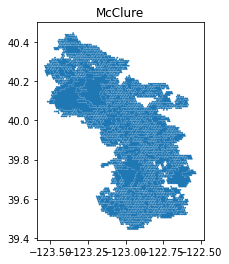

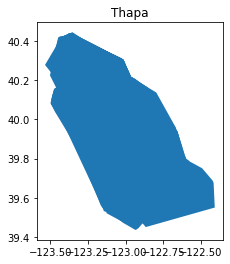

In [5]:
ac_mcclure.plot()
plt.title('McClure')
plt.show()

ac_thapa_poly.plot()
plt.title('Thapa')
plt.show()

## Generate time series

In [29]:
#combine into daily polygons

days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]
ac_mcclure['Days'] = days
ac_mcclure_daily= ac_mcclure.dissolve(by='Days', aggfunc='sum',as_index=False)
ac_mcclure_daily

,Days,geometry,FRP,pixels,Grwth_A,wthn_bn
0,2020-08-17,"MULTIPOLYGON (((-122.81597 39.68307, -122.8162...",8082.900121,52,8.827660e+03,2
1,2020-08-18,"MULTIPOLYGON (((-122.85415 39.64974, -122.8544...",1682.200025,24,3.937226e+03,1
2,2020-08-19,"MULTIPOLYGON (((-122.96370 39.51640, -122.9639...",265009.003975,465,8.200006e+04,3
3,2020-08-20,"MULTIPOLYGON (((-122.65388 39.53922, -122.6537...",149680.102245,851,8.722313e+04,3
4,2020-08-21,"MULTIPOLYGON (((-122.74720 39.52744, -122.7473...",42351.700635,528,3.148659e+04,3
...,...,...,...,...,...,...
56,2020-10-14,"POLYGON ((-123.39349 40.20245, -123.39359 40.2...",175.100003,6,1.841330e+02,1
57,2020-10-15,"MULTIPOLYGON (((-123.40024 40.19395, -123.4001...",3891.300058,55,7.353029e+02,2
58,2020-10-16,"MULTIPOLYGON (((-123.42871 40.18561, -123.4288...",766.000011,28,9.499642e+02,4
59,2020-10-17,"POLYGON ((-123.10245 40.25245, -123.10255 40.2...",277.800004,6,3.290000e-13,1


### MERRA Time Series

In [62]:
#MERRA Time Series

times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros((2, len(times)))
vpd=np.zeros((2, len(times)))
num_points = np.zeros((2, len(times)))
frp = np.zeros((2, len(times)))

varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path:
        path = path.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path = path.replace('400', '401')
    dat = nc.Dataset(path)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][12,:,:]
    Q = dat['QLML'][12,:,:]
    P = dat['PS'][12,:,:]
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_att['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_att['Number of VIIRS points'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_att['Number of VIIRS points'].iloc[thapa_ind[0]]
    

0
0 both polys
1
1 both polys
2
2 both polys
3
3 both polys
4
4 both polys
5
5 both polys
6
6 both polys
7
7 both polys
8
8 both polys
9
9 both polys
10
10 both polys
11
11 both polys
12
12 both polys
13
13 both polys
14
14 both polys
15
15 both polys
16
16 both polys
17
17 both polys
18
18 both polys
19
19 both polys
20
20 both polys
21
21 both polys
22
22 both polys
23
23 both polys
24
24 both polys
25
25 both polys
26
26 both polys
27
27 both polys
28
28 both polys
29
29 both polys
30
30 both polys
31
31 both polys
32
32 both polys
33
33 both polys
34
34 both polys
35
35 both polys
36
36 both polys
37
37 both polys
38
38 both polys
39
39 both polys
40
40 both polys
41
41 both polys
42
42 both polys
43
43 both polys
44
44 both polys
45
45 both polys
46
46 both polys
47
47 both polys
48
48 both polys
49
49 both polys
50
50 both polys
51
51 both polys
52
52 both polys
53
53 both polys
54
54 both polys
55
55 No mcclure poly
56
56 both polys
57
57 No mcclure poly
58
58 both polys
59
59 b

In [52]:
print(temp, vpd)

[[301.06220855 300.60319043 299.77431264 291.89163833 292.05166559
  291.73093153 296.00334622 295.16913533 295.7074567  293.29317959
  292.53168376 296.41762892 296.22565824 293.19471379 293.57991918
  294.20112222 295.42217317 293.8048906  292.10562649 297.16119943
  300.61390404 302.18318699 290.59473767 290.72242561 290.54595379
  288.73200944 290.55716226 291.73981487 290.30017418 289.43882927
  289.61377759 289.04141633 284.72467807 284.26937439 288.46611129
  289.43547317 285.26635742 286.0050023  286.52531443 284.09753075
  286.11692326 285.52468736 290.2191449  293.77416506 292.63517987
  297.59656441 295.73762362 294.91422449 289.49106321 291.62537644
  292.43152298 290.79397271 286.94252473 284.96163686 283.55319512
           nan 281.88317871          nan 284.9727478  286.31604283
  289.17057275 292.87055298]
 [301.76858521 300.92922974 298.99540622 292.12137428 293.22077808
  294.18820627 296.86230756 296.04624496 296.62917665 294.91046416
  292.63133064 296.56032607 296.9

### FCCS Time Series

In [97]:
varis = {'/static_maps/static_map_1km.nc4': ['fccs', 'slp', 'asp']}
#0=lat, 1=lon, 2=time, 3=level 
dims = {'/static_maps/static_map_1km.nc4': ['lat', 'lon']}

times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
fuels = np.zeros((2, len(times)))
slopes = np.zeros((2, len(times)))
aspects = np.zeros((2, len(times)))

# load in the FCCS Data
path = '../static_maps/static_map_1km.nc4'
dat = nc.Dataset(path)  

lat = dat['lat'][:]
lon = dat['lon'][:]
fccs = dat['fccs'][:]
slp = dat['slp'][:]
asp = dat['asp'][:]

if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat) 
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)



for ii in range(1):#range(len(times)):
    print(ii)
    
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_att['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    overlap_thapa_poly = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
    overlap_thapa_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0].buffer(0.05)) #0.05 degree buffer to check fuels 
    
    fuels_thapa = fccs[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)]
    slopes_thapa = slp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)]
    
    
    
    

0
[  7.   7. 602.   7.   7.   7.   7. 635. 635. 611. 601.   7. 627. 635.
 623. 615.  70.   0.  41. 611. 635. 635. 611. 601. 635.   0. 611. 611.
 627. 627. 615. 615. 615. 615. 615. 602. 601. 635. 611. 615. 615. 610.
 615. 635. 623. 615. 615. 611. 623. 615. 615. 611. 615. 615. 611. 635.
 611. 610. 611. 610. 611. 635. 611. 615. 615. 602. 601. 615. 627. 615.
 611. 611. 611. 635. 635. 601. 611. 627. 627.   7.   7.   7. 627. 635.
 611. 610. 611. 610. 611. 635. 611. 615. 615. 602. 601. 615. 627. 615.
 611. 611. 611. 635. 635. 601. 611. 627. 627.  41.   7.   7. 635. 635.
 611. 610. 635. 635. 610. 610. 601. 602. 611. 610. 610.   0. 601.   0.
 611. 610. 610. 630. 627. 611. 635. 635. 602. 630. 611. 602.  41.  44.
   7.  46. 611.   7.   7. 627. 627. 611. 610. 602. 611. 611. 611. 610.
 610. 611. 635. 635. 611. 601. 611. 601. 601. 630. 602. 602. 630. 630.
 602. 611. 611. 602. 602.   4.   7.  15.  15.  15.  41.  46.   7.   7.
   7.   7. 610. 635. 611. 611. 611. 611. 611. 601. 601. 611. 611. 611.
 615

In [95]:
print(np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)) #this should be the buffer 

(array([1004, 1004, 1004, 1004, 1004, 1004, 1004, 1005, 1005, 1005, 1005,
       1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1006, 1006, 1006,
       1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006,
       1006, 1006, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007,
       1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007,
       1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008,
       1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008, 1008,
       1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009,
       1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1010,
       1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010,
       1010, 1010, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1011, 1011,
       1011, 1011, 1011, 1011, 1011, 1011, 1011, 1

In [ ]:
if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_att['Number of VIIRS points'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_att['Number of VIIRS points'].iloc[thapa_ind[0]]
    

## plot time series

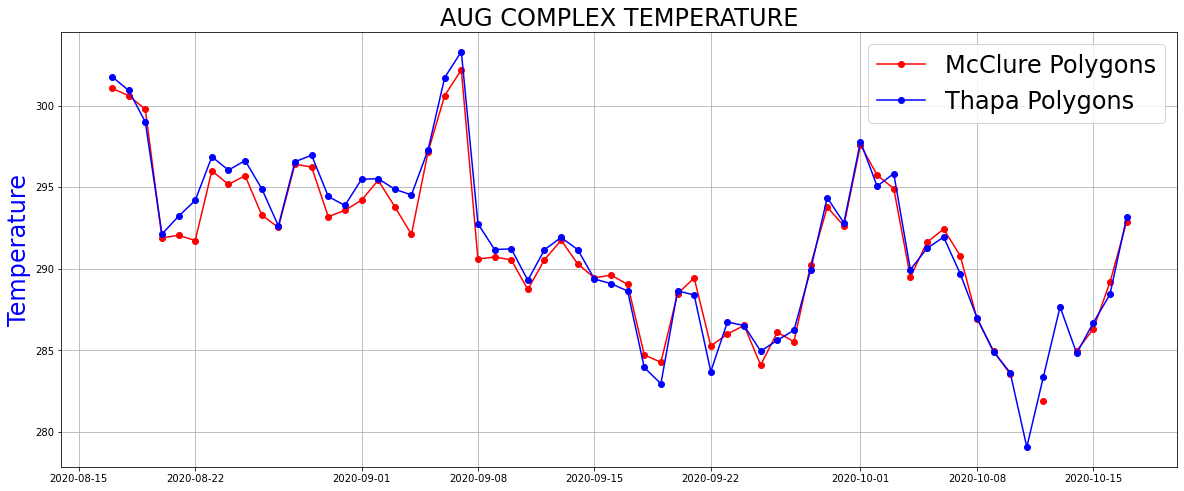

In [63]:
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.plot(times, temp[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX TEMPERATURE',fontsize=24)
plt.grid()
plt.show()

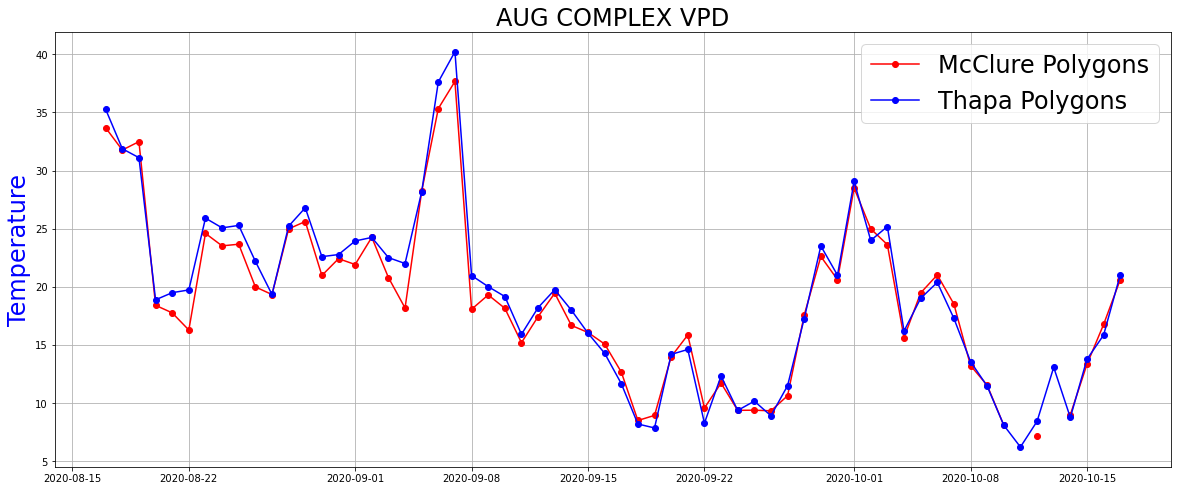

In [64]:
#compare VPD for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.plot(times, vpd[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX VPD',fontsize=24)
plt.grid()
plt.show()

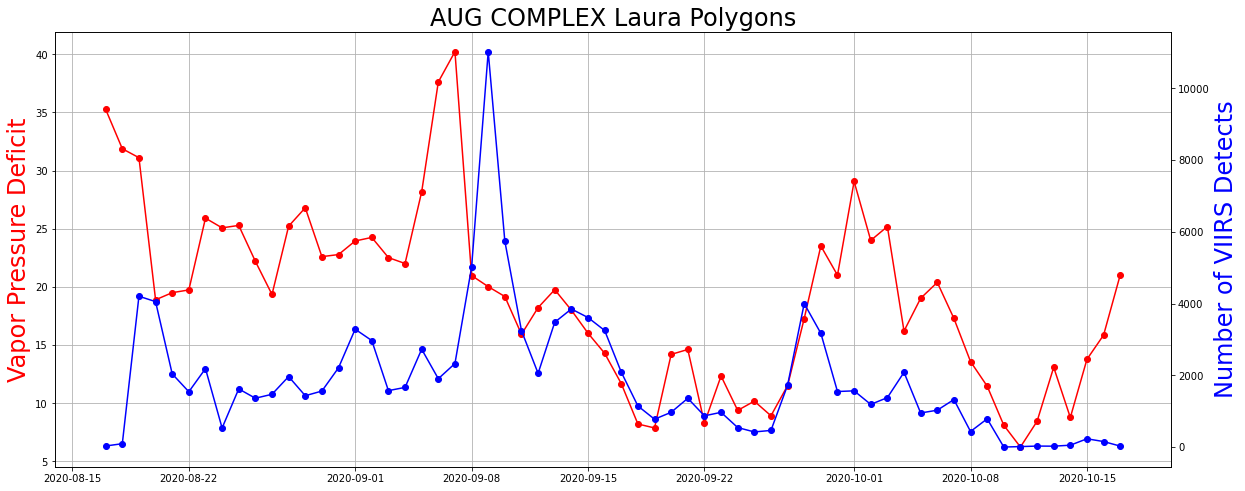

In [71]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[1,:], 'ro-')
ax.set_ylabel('Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

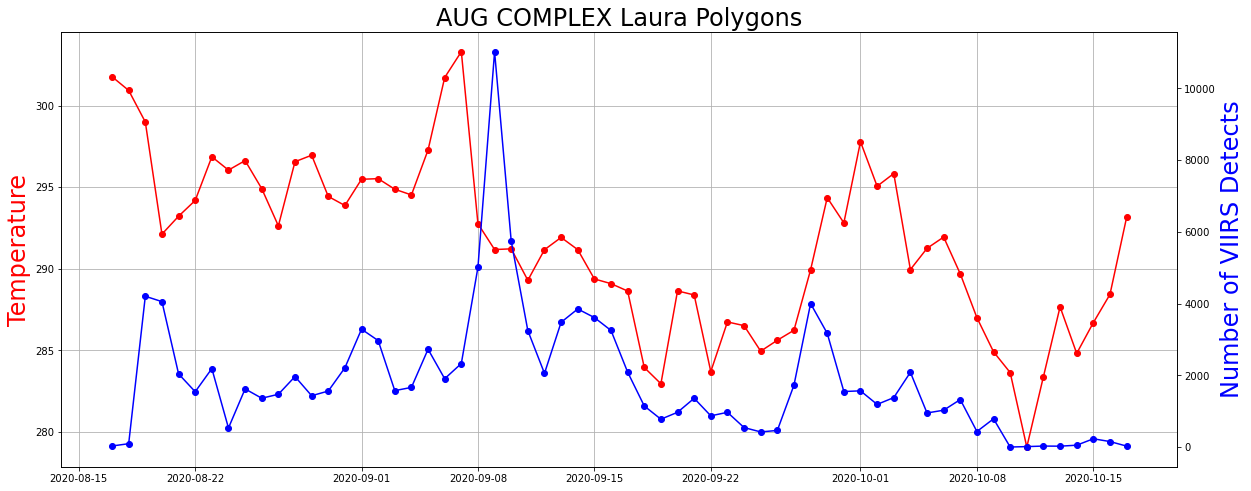

In [72]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[1,:], 'ro-')
ax.set_ylabel('Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

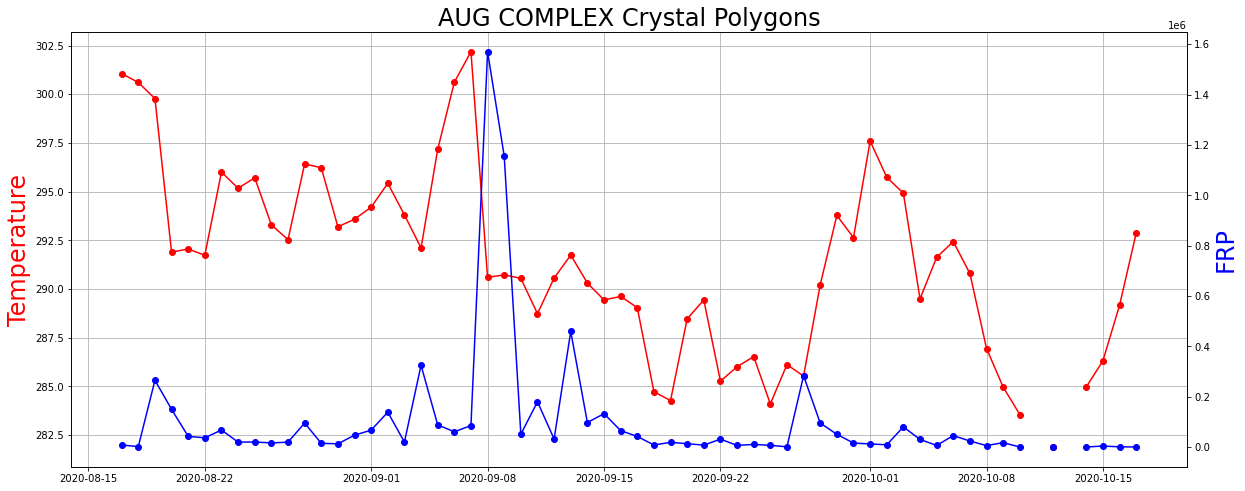

In [73]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.set_ylabel('Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

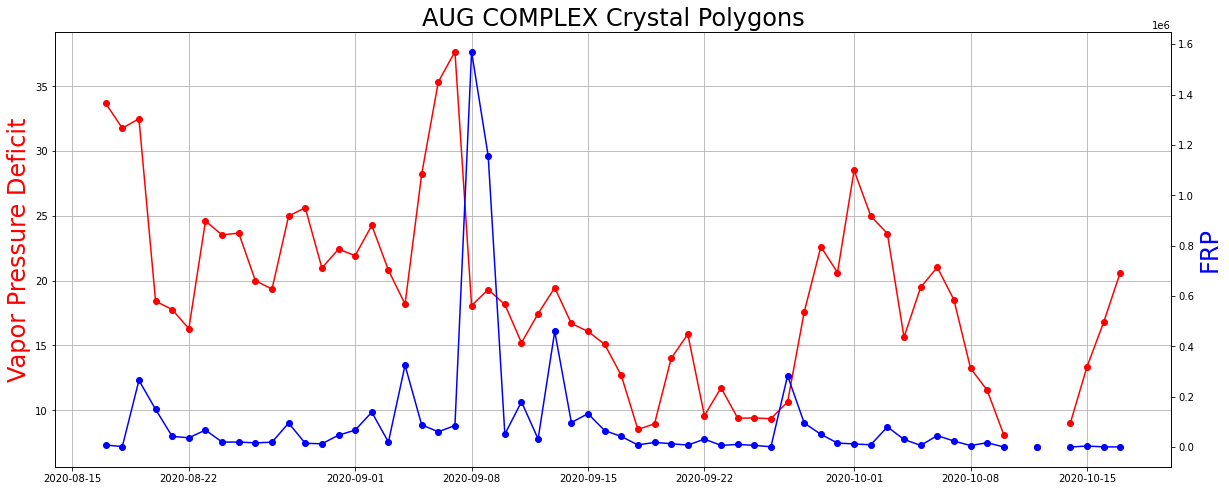

In [74]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.set_ylabel('Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

In [ ]:
if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
    overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
    
    poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
    overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])

## Helper Functions

In [ ]:
def choose_plot_grid_size(days):
    n_days = len(days)
    sizes = np.linspace(1,16, 16)
    squares = sizes**2
    side = np.amin(np.where(squares>n_days))+1
    nrows = side
    ncols = side
    return nrows, ncols

In [8]:
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(lat.shape[0]-1),  0:(lat.shape[1])-1] + LAT[1:(lat.shape[0]), 1:(lat.shape[1])])/2
    lon_corners = (LON[0:(lat.shape[0]-1),  0:(lat.shape[1])-1] + LON[1:(lat.shape[0]), 1:(lat.shape[1])])/2
    return lat_corners, lon_corners

In [38]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape):
    overlaps = np.zeros(lat.shape)
    # buffer the fire shape so it has a non zero area
    if fire_shape.area ==0:
        fire_shape = fire_shape.buffer(0.01)
    fire_shape = fire_shape.buffer(0)
    #print(fire_shape.area)
    #buffer again by 1 degree so we can get the lat start and lat stop
    fire_shape_buff = fire_shape.buffer(1)
    # get the bounds of the buffered polygon
    w,s,e,n = fire_shape_buff.bounds
    lat_start = np.unique(np.argmin(np.abs(lat-s), axis=0))[0]
    lat_stop = np.unique(np.argmin(np.abs(lat-n), axis=0))[0]
    lon_start = np.unique(np.argmin(np.abs(lon-w), axis=1))[0]
    lon_stop = np.unique(np.argmin(np.abs(lon-e), axis=1))[0]
    
    # find the intersection between the first day's polygon and the  grid
    for ii in range(lat_start, lat_stop):
        for jj in range(lon_start, lon_stop):
            #print('ctr', lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]), (lon_corners[ii, jj],lat_corners[ii, jj]), (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]), (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            overlap_cell = fire_shape.intersection(poly_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    
    return overlaps

## Plot the mcclure daily polygons


In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    ac_mcclure_daily.loc[[ii],'geometry'].plot(figsize=(7,6))
    plt.show()

In [ ]:
ac_thapa_poly_plot = ac_thapa_poly.reset_index(drop=True)
print(ac_thapa_poly_plot)

for ii in range(len(ac_thapa_poly)):
    print(ii)
    ac_thapa_poly_plot.loc[[ii],'geometry'].plot(figsize=(7,6))
    
    plt.show()

In [ ]:
40.0 -123.125

poly_cell = Polygon([(-123.375,39.75), 
                     (-123.375,40.25), 
                     (-122.875,40.25), 
                     (-122.875, 39.75)])

test = ac_mcclure_daily['geometry'].iloc[5]

ser = gpd.GeoDataFrame({'col1': ['name1', 'name2'],'geometry':[test, poly_cell]})
print(ser)
ser.plot()
plt.show()

In [ ]:
test = ac_mcclure_daily.loc[[5],'geometry']
test_buffer = ac_mcclure_daily.loc[[5],'geometry'].buffer(0)

test.plot()
plt.show()

test_buffer.plot()
plt.show()

In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    w,e,s,n = ac_mcclure_daily['geometry'].iloc[ii].bounds